In [1]:
!git clone https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch.git

Cloning into 'Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch'...
remote: Enumerating objects: 598, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 598 (delta 50), reused 35 (delta 34), pack-reused 534
Receiving objects: 100% (598/598), 157.64 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (327/327), done.


In [2]:
cd /content/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch

/content/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch


In [3]:
!pip install transformers
!pip install diffusers
!pip install folium==0.9.1
!pip install huggingface-hub
!pip install pillow==9.0.0
!pip install scikit-image==0.19.2
!pip install accelerate
!pip install git+https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch.git@dev
!pip install git+https://github.com/openai/glide-text2im

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 35.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 12.5 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.12.1.post1
    Uninstalling folium-0.12.1.post1:
      Successfully uninstalled folium-0.12.1.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 19.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch.git (to revision dev) to /tmp/pip-req-build-sfd574nc
  Running command git clone --filter=blob:none --quiet https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch.git /tmp/pip-req-build

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [6]:
import os
import time
import torch
import glob
import argparse
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import open3d.visualization.rendering as rendering

from PIL import Image
from tqdm.auto import tqdm
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud

# create folders
plt_plot_folder = './plt_results'
mesh_folder = './mesh_results'
viewpoint_folder = './frame_results'
video_folder = './video_results'

os.makedirs(plt_plot_folder, exist_ok=True)
os.makedirs(mesh_folder, exist_ok=True)
os.makedirs(viewpoint_folder, exist_ok=True)
os.makedirs(video_folder, exist_ok=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:07<00:00, 128MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

creating SDF model...
loading SDF model...


  0%|          | 0.00/38.0M [00:00<?, ?iB/s]

<All keys matched successfully>

In [8]:
def generate_pcd(prompt_list, sampler):
    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=prompt_list))):
        samples = x
    return samples


def generate_fig(samples, sampler):
    pc = sampler.output_to_point_clouds(samples)[0]
    fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))
    return fig, pc


def generate_mesh(pc):
    mesh = marching_cubes_mesh(
        pc=pc,
        model=model,
        batch_size=4096,
        grid_size=128,  # increase to 128 for resolution used in evals
        progress=True,
    )
    return mesh


# generate 360 video
def generate_video(mesh_path):
    render = rendering.OffscreenRenderer(640, 480)
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh.compute_vertex_normals()

    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = 'defaultLit'

    render.scene.camera.look_at([0, 0, 0], [1, 1, 1], [0, 0, 1])
    render.scene.add_geometry('mesh', mesh, mat)

    def update_geometry():
        render.scene.clear_geometry()
        render.scene.add_geometry('mesh', mesh, mat)

    def generate_images():
        for i in range(64):
            # Rotation
            R = mesh.get_rotation_matrix_from_xyz((0, 0, np.pi / 32))
            mesh.rotate(R, center=(0, 0, 0))
            # Update geometry
            update_geometry()
            img = render.render_to_image()
            o3d.io.write_image(os.path.join(viewpoint_folder, "{:05d}.jpg".format(i)), img, quality=100)
            time.sleep(0.05)

    generate_images()
    image_list = []
    for filename in sorted(glob.glob(f'{viewpoint_folder}/*.jpg')):  # assuming gif
        im = Image.open(filename)
        image_list.append(im)
    return image_list

In [9]:
prompt = "a cake | a house" #@param{type: 'string'}
scales = "7.5 | 5.0" #@param{type: 'string'}

prompts = [x.strip() for x in prompt.split("|")]
scales = [float(x.strip()) for x in scales.split("|")]

print(prompts, scales)

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[scales, 0.0],
    model_kwargs_key_filter=('texts', ''),  # Do not condition the upsampler at all
)

['a cake', 'a house'] [7.5, 5.0]


0it [00:00, ?it/s]

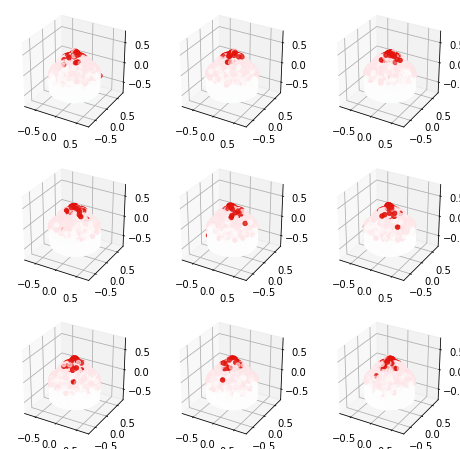

In [10]:
file_name = "_".join(prompts)
pcd = generate_pcd(prompts, sampler)

# save fig visualization
fig, pc = generate_fig(pcd, sampler)
fig.show()

In [12]:
# save mesh file
mesh = generate_mesh(pc)
mesh_path = os.path.join(mesh_folder, f'{file_name}_{scales}.ply')
with open(mesh_path, 'wb') as f:
    mesh.write_ply(f)

# generate video
image_frames = generate_video(mesh_path)
gif_path = os.path.join(video_folder, f'{file_name}.gif')
image_frames[0].save(gif_path, save_all=True, optimizer=False, duration=5, append_images=image_frames[1:], loop=0)

  0%|          | 0/512 [00:00<?, ?it/s]

AttributeError: ignored

In [13]:
from IPython import display

display.Image(open(gif_path, 'rb').read())



NameError: ignored

In [1]:
import torch

from PIL import Image
from torch import autocast
from composable_diffusion.composable_stable_diffusion.pipeline_composable_stable_diffusion import ComposableStableDiffusionPipeline

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
print(device)

# initialize stable diffusion model
pipe = ComposableStableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    use_auth_token=True
).to(device)

cuda


Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/911 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

composing ['a photo of jackson', 'a photo of Biden']...


  0%|          | 0/50 [00:00<?, ?it/s]

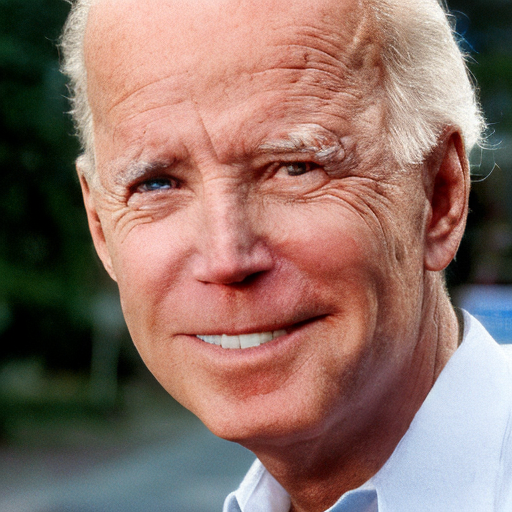

In [4]:
import torch as th
from IPython.display import display

# Sampling parameters
#@markdown Here is an example of composing sentences using conjunction operator (AND). \
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.\
#@markdown `weight`: weight indicates the weight importance of sentence when composing, also using `|` as the delimiter. \
#@markdown `scale`: default weight for each prompt
prompt = "a photo of jackson | a photo of Biden" #@param{type: 'string'}
weights = "7.5 | 2.5" #@param{type: 'string'}
scale = 7.5 #@param{type: 'number'}
steps = 50 #@param{type: 'number'}
seed = 0 #@param{type: 'number'}
generator = th.Generator('cuda').manual_seed(seed)

image = pipe(prompt, guidance_scale=scale, generator=generator,
              num_inference_steps=steps, weights=weights).images[0]
display(image)

composing ['A castle in a forest', 'grainy, fog']...


  0%|          | 0/50 [00:00<?, ?it/s]

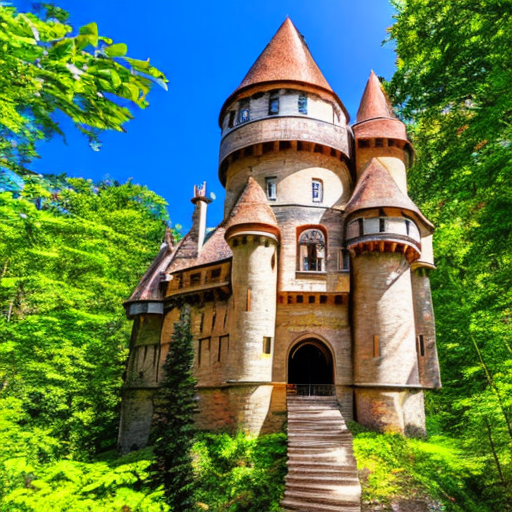

In [5]:
# Sampling parameters
#@markdown Here is an example of composing sentences using <b>Negation operator (NOT).</b> \
#@markdown <b>Negative weights should be assigned to the textes you wish to negate.</b> \
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.\
#@markdown `weight`: weight indicates the weight importance of sentence when composing, also using `|` as the delimiter.
prompt = "A castle in a forest | grainy, fog" #@param{type: 'string'}
weights = "7.5 | -7.5" #@param{type: 'string'}
scale = 7.5 #@param{type: 'number'}
steps = 50 #@param{type: 'number'}
seed = 100 #@param{type: 'number'}
generator = th.Generator('cuda').manual_seed(seed)

image = pipe(prompt, guidance_scale=scale, generator=generator,
              num_inference_steps=steps, weights=weights).images[0]
display(image)

In [6]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)


In [7]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [8]:
# Create base model.
timestep_respacing =  100 #@param{type: 'number'}
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = str(timestep_respacing) # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726
